In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-03
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [6]:
criteria = CostSensitiveRegularizedLoss(n_classes=num_of_class, base_loss='focal_loss', reduction='mean') 
optimizer = torch.optim.SGD(resnet1.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=1e-1)
model_name = 'focalloss-aug.pth'

Epoch: 1/10, Train Loss: 2.5497877395460966,  Validation Loss: 2.3605024814605713
Validation Loss Decreased(inf ---> 2.3605024814605713)
Epoch: 2/10, Train Loss: 2.1918997051970983,  Validation Loss: 2.1458323001861572
Validation Loss Decreased(2.3605024814605713 ---> 2.1458323001861572)
Epoch: 3/10, Train Loss: 2.0429964017164224,  Validation Loss: 2.068101708705609
Validation Loss Decreased(2.1458323001861572 ---> 2.068101708705609)
Epoch: 4/10, Train Loss: 1.9810232434325552,  Validation Loss: 2.0599818779872012
Validation Loss Decreased(2.068101708705609 ---> 2.0599818779872012)
Epoch: 5/10, Train Loss: 1.9675067557619947,  Validation Loss: 2.0964393524023204
Epoch: 6/10, Train Loss: 1.9959682067821827,  Validation Loss: 2.165790374462421
Epoch: 7/10, Train Loss: 2.0598285180616203,  Validation Loss: 2.255103881542499
Epoch: 8/10, Train Loss: 2.1588039811686834,  Validation Loss: 2.347843041786781
Epoch: 9/10, Train Loss: 2.253788910228828,  Validation Loss: 2.40657272705665
Epoch:

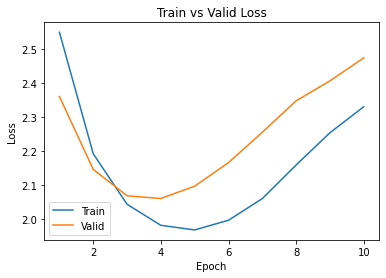

In [7]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=10, model_name=model_name)

In [8]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 7.3978166580200195
Minimum: 0.0, Maximum: 48.0, Median: 6.0
Mean Absolute Error: 6.835201644897461
Minimum: 0.0, Maximum: 49.0, Median: 5.0


In [9]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 34.00
2  No Sample
3 : 2 : 28.50
4 : 1 : 31.00
5 : 1 : 23.00
6 : 2 : 22.00
7 : 2 : 22.00
8 : 2 : 23.50
9 : 1 : 19.00
10 : 3 : 22.67
11 : 4 : 18.75
12 : 3 : 17.33
13 : 4 : 18.00
14 : 5 : 16.20
15 : 9 : 13.44
16 : 10 : 12.80
17 : 16 : 11.81
18 : 24 : 11.62
19 : 22 : 10.00
20 : 32 : 10.12
21 : 33 : 8.06
22 : 37 : 8.65
23 : 42 : 7.26
24 : 52 : 6.92
25 : 57 : 4.93
26 : 55 : 4.07
27 : 61 : 4.77
28 : 69 : 3.75
29 : 62 : 3.90
30 : 77 : 3.23
31 : 63 : 5.13
32 : 75 : 4.91
33 : 67 : 4.69
34 : 72 : 5.44
35 : 82 : 4.73
36 : 69 : 5.12
37 : 74 : 6.27
38 : 76 : 5.83
39 : 64 : 6.22
40 : 77 : 6.34
41 : 64 : 6.08
42 : 71 : 7.20
43 : 65 : 7.65
44 : 56 : 8.07
45 : 68 : 7.01
46 : 57 : 7.91
47 : 58 : 7.07
48 : 62 : 8.08
49 : 53 : 8.83
50 : 63 : 8.51
51 : 57 : 8.00
52 : 62 : 9.15
53 : 50 : 7.50
54 : 51 : 8.39
55 : 59 : 9.88
56 : 45 : 7.73
57 : 49 : 9.41
58 : 49 : 7.96
59 : 43 : 8.28
60 : 49 : 7.53
61 : 41 : 8.32
62 : 48 : 7.77
63 : 44 : 6.98
64 : 39 : 8.21
65 : 46 : 5.89
66

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/10, Train Loss: 1.9113213085866236,  Validation Loss: 2.064310440650353
Validation Loss Decreased(inf ---> 2.064310440650353)
Epoch: 2/10, Train Loss: 1.8834970442803352,  Validation Loss: 2.068317248271062
Epoch: 3/10, Train Loss: 1.860955834388733,  Validation Loss: 2.0755570851839504
Epoch: 4/10, Train Loss: 1.8404606397335346,  Validation Loss: 2.089746356010437
Epoch: 5/10, Train Loss: 1.8397495602513407,  Validation Loss: 2.106857703282283
Epoch: 6/10, Train Loss: 1.8406613305374817,  Validation Loss: 2.188012434886052
Epoch: 7/10, Train Loss: 1.8590041464501685,  Validation Loss: 2.1494343280792236
Epoch: 8/10, Train Loss: 1.8779431188499534,  Validation Loss: 2.1969324075258694
Epoch: 9/10, Train Loss: 1.9133659051014826,  Validation Loss: 2.2028550184690037
Epoch: 10/10, Train Loss: 1.9406616072078327,  Validation Loss: 2.220918765434852


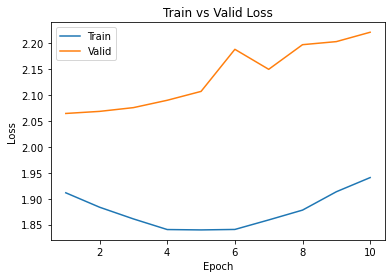

In [13]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = CostSensitiveRegularizedLoss(n_classes=num_of_class, base_loss='focal_loss', reduction='mean') 
optimizer = torch.optim.SGD(resnet2.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=1e-1)
model_name = 'focalloss.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=10, model_name=model_name)

In [14]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 7.603395938873291
Minimum: 0.0, Maximum: 50.0, Median: 6.0
Mean Absolute Error: 5.7506279945373535
Minimum: 0.0, Maximum: 45.0, Median: 5.0


In [15]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 39.00
2  No Sample
3 : 2 : 35.50
4 : 1 : 31.00
5 : 1 : 23.00
6 : 2 : 22.00
7 : 2 : 22.00
8 : 2 : 23.50
9 : 1 : 21.00
10 : 3 : 26.00
11 : 4 : 21.00
12 : 3 : 18.67
13 : 4 : 19.75
14 : 5 : 17.00
15 : 9 : 14.67
16 : 10 : 13.70
17 : 16 : 12.00
18 : 24 : 12.33
19 : 22 : 10.36
20 : 32 : 10.81
21 : 33 : 8.73
22 : 37 : 8.59
23 : 42 : 7.38
24 : 52 : 6.87
25 : 57 : 5.25
26 : 55 : 5.58
27 : 61 : 4.95
28 : 69 : 4.28
29 : 62 : 4.27
30 : 77 : 3.06
31 : 63 : 4.60
32 : 75 : 4.92
33 : 67 : 4.30
34 : 72 : 5.24
35 : 82 : 5.50
36 : 69 : 5.13
37 : 74 : 6.05
38 : 76 : 5.83
39 : 64 : 6.06
40 : 77 : 5.56
41 : 64 : 6.12
42 : 71 : 6.41
43 : 65 : 7.42
44 : 56 : 7.75
45 : 68 : 7.31
46 : 57 : 8.23
47 : 58 : 7.14
48 : 62 : 9.27
49 : 53 : 9.60
50 : 63 : 8.51
51 : 57 : 8.47
52 : 62 : 9.23
53 : 50 : 7.68
54 : 51 : 7.47
55 : 59 : 10.81
56 : 45 : 8.00
57 : 49 : 9.27
58 : 49 : 8.12
59 : 43 : 8.81
60 : 49 : 7.92
61 : 41 : 7.80
62 : 48 : 7.46
63 : 44 : 7.30
64 : 39 : 8.26
65 : 46 : 5.80
6